In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

gdp = pd.read_csv('data/gdp.csv')
inflation = pd.read_csv('data/inflation.csv')
unemployment = pd.read_csv('data/unemployment.csv')
yield_data = pd.read_csv('data/yield.csv') 
yield_data['Date'] = pd.to_datetime(yield_data['Date'], errors='coerce')
yield_data.set_index('Date', inplace=True)


### Yield curves

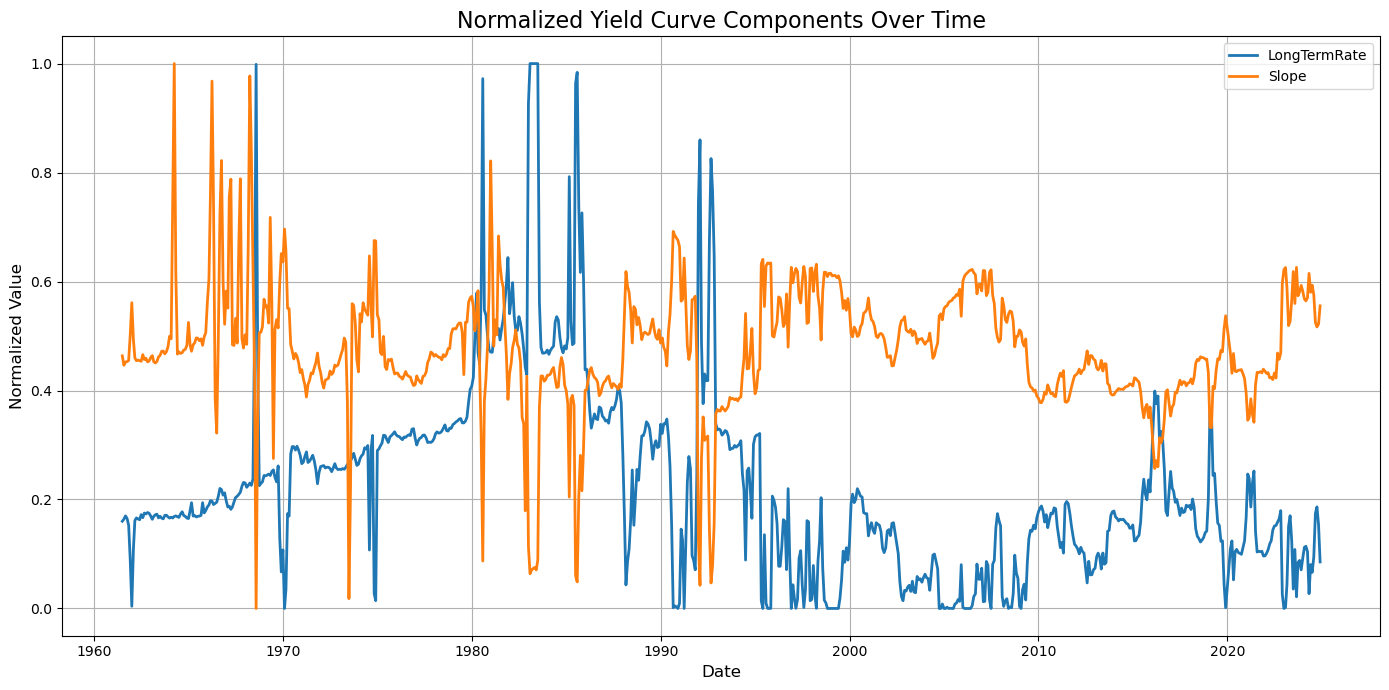

In [52]:
from sklearn.preprocessing import MinMaxScaler

# Convert to datetime and set as index


# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
specific_columns_to_drop = ["SVEN1F01", "SVEN1F04", "SVEN1F09"]
columns_to_drop = columns_to_drop.union(specific_columns_to_drop)

# Drop the identified columns
yield_data = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}

# https://www.federalreserve.gov/pubs/feds/2006/200628/200628pap.pdf   <=== labels for the columns plus info on data
for i in range(1, 30):
    column_rename_mapping[f'SVENY{i:02d}'] = f'ZeroCouponYield{i}Y'
    column_rename_mapping[f'SVENF{i:02d}'] = f'InstantaneousForwardRate{i}Y'
yield_data.rename(columns=column_rename_mapping, inplace=True)

columns_of_interest = ['LongTermRate', 'Slope', 'ZeroCouponYield2Y', 'ZeroCouponYield10Y','InstantaneousForwardRate2Y', 'InstantaneousForwardRate10Y'] 
yield_data = yield_data[columns_of_interest]

# Interpolate missing values for continuous features, including key features
yield_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

# Resample to monthly frequency (convert from 'B' to 'M')
yield_data = yield_data.resample('M').mean()

# Normalize continuous features (focus on LongTermRate and Slope)
scaler = MinMaxScaler()
yield_data[columns_of_interest] = scaler.fit_transform(yield_data[columns_of_interest])

# Display the first few rows of the processed dataset
#print(yield_data.head())

# Plot: Line plot for LongTermRate and Slope
plt.figure(figsize=(14, 7))
plt.plot(yield_data.index, yield_data['LongTermRate'], label='LongTermRate', linewidth=2)
plt.plot(yield_data.index, yield_data['Slope'], label='Slope', linewidth=2)

# Add labels, legend, and title
plt.title('Normalized Yield Curve Components Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


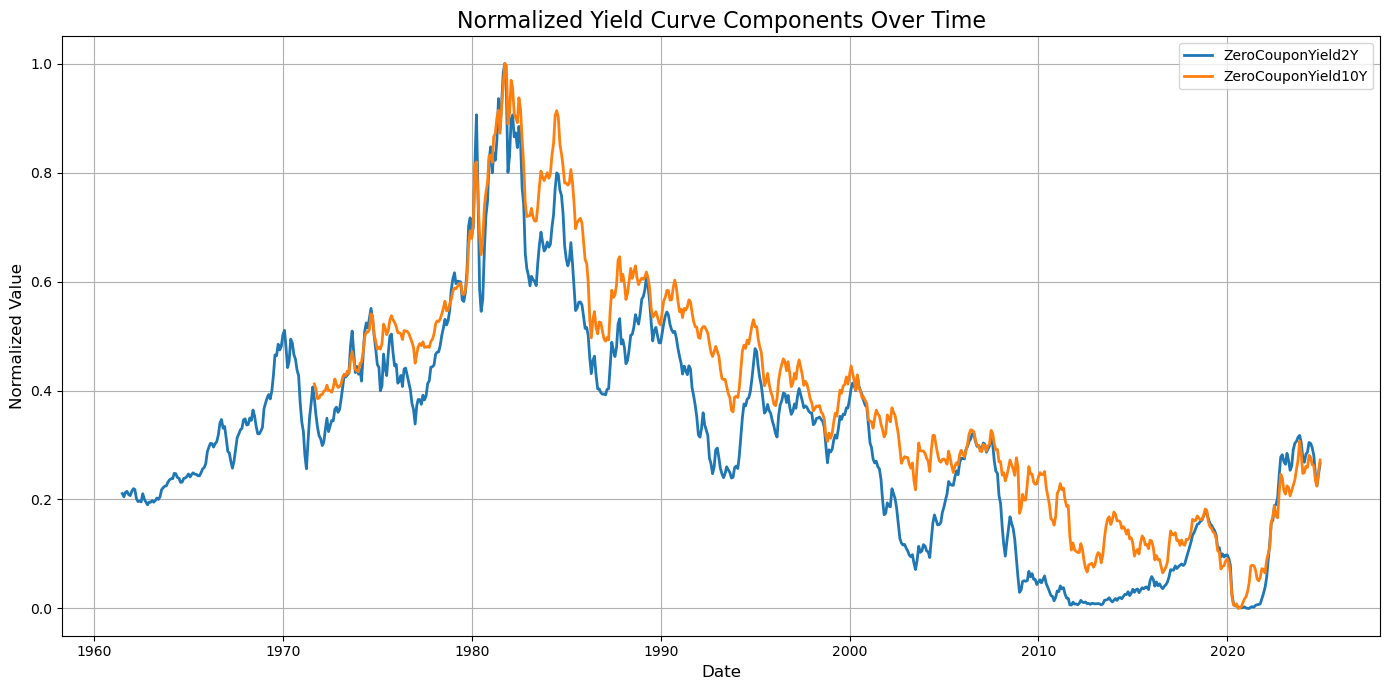

In [53]:
# Plot: Line plot for LongTermRate and Slope
plt.figure(figsize=(14, 7))
plt.plot(yield_data.index, yield_data['ZeroCouponYield2Y'], label='ZeroCouponYield2Y', linewidth=2)
plt.plot(yield_data.index, yield_data['ZeroCouponYield10Y'], label='ZeroCouponYield10Y', linewidth=2)

# Add labels, legend, and title
plt.title('Normalized Yield Curve Components Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Unemployment

            overall_rate  men_rate  women_rate  men_16_17_rate  \
date                                                             
1948-01-31      0.073171       3.4         3.3             9.7   
1948-02-29      0.105691       3.6         4.5            13.0   
1948-03-31      0.121951       3.8         4.4            14.0   
1948-04-30      0.113821       3.8         4.3            11.6   
1948-05-31      0.081301       3.5         3.7             7.1   

            women_16_17_rate  men_16_19_rate  women_16_19_rate  \
date                                                             
1948-01-31               8.8             9.4               7.2   
1948-02-29              13.2            10.8               8.9   
1948-03-31              11.4            11.9               8.6   
1948-04-30              10.6             9.8               9.2   
1948-05-31               5.4             7.6               6.1   

            men_18_19_rate  women_18_19_rate  men_16_24_rate  ...  \
date 

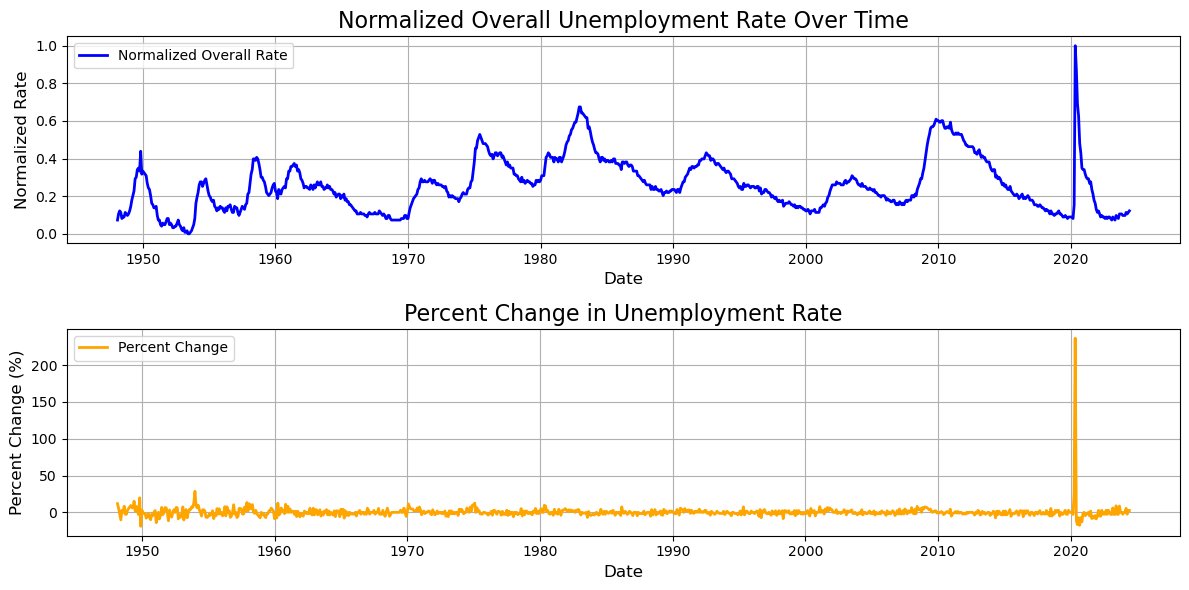

In [54]:
from sklearn.preprocessing import MinMaxScaler

# Convert to datetime and set index
unemployment['date'] = pd.to_datetime(unemployment['date'], errors='coerce')
unemployment.set_index('date', inplace=True)
unemployment.sort_index(inplace=True)

# Resample to monthly frequency
unemployment = unemployment.resample('M').mean()

# Find and fill all missing data while dropping columns that don't meet the threshold
threshold = 0.2 * len(unemployment)
columns_to_drop = unemployment.columns[unemployment.isnull().sum() > threshold]
unemployment = unemployment.drop(columns=columns_to_drop)
unemployment.interpolate(method='linear', inplace=True)  # Use linear interpolation for filling NA values

# Calculate percent change for 'overall_rate'
unemployment['unemployment_percent_change'] = unemployment['overall_rate'].pct_change() * 100

# Normalize 'overall_rate' using MinMaxScaler
scaler = MinMaxScaler()
unemployment['overall_rate'] = scaler.fit_transform(unemployment[['overall_rate']])

# Display the first few rows
print(unemployment.head())

# Plot normalized overall rate
plt.figure(figsize=(12, 6))

# Original Unemployment Rate
plt.subplot(2, 1, 1)
plt.plot(unemployment.index, unemployment['overall_rate'], label='Normalized Overall Rate', color='blue', linewidth=2)
plt.title('Normalized Overall Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Rate', fontsize=12)
plt.legend()
plt.grid(True)

# Percent Change
plt.subplot(2, 1, 2)
plt.plot(unemployment.index, unemployment['unemployment_percent_change'], label='Percent Change', color='orange', linewidth=2)
plt.title('Percent Change in Unemployment Rate', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Inflation

            value  value_normalized  inflation_percent_change
date                                                         
1947-02-28  21.62          0.000496                  0.651769
1947-03-31  22.00          0.001842                  1.757632
1947-04-30  22.00          0.001842                  0.000000
1947-05-31  21.95          0.001665                 -0.227273
1947-06-30  22.08          0.002125                  0.592255


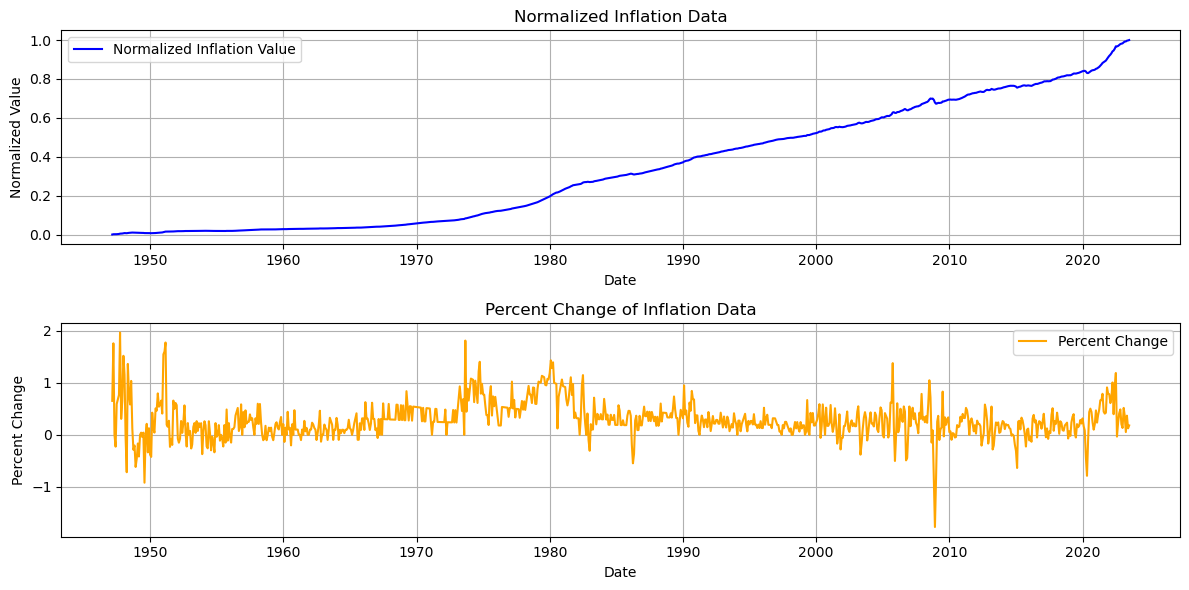

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is set as index
inflation['date'] = pd.to_datetime(inflation['date'], errors='coerce')
inflation.set_index('date', inplace=True)
inflation.sort_index(inplace=True)

# Resample to ensure monthly frequency
inflation = inflation.resample('M').mean()

# Fill missing values using linear interpolation
inflation.interpolate(method='linear', inplace=True)

# Normalize the 'value' column
inflation['value_normalized'] = (inflation['value'] - inflation['value'].min()) / (inflation['value'].max() - inflation['value'].min())

# Calculate the percent change
inflation['inflation_percent_change'] = inflation['value'].pct_change() * 100

# Drop NaN values resulting from percent change calculation
inflation = inflation.dropna(subset=['inflation_percent_change'])

print(inflation.head())

# Plot the normalized original data and percent change
plt.figure(figsize=(12, 6))

# Normalized Inflation Data
plt.subplot(2, 1, 1)
plt.plot(inflation.index, inflation['value_normalized'], label='Normalized Inflation Value', color='blue')
plt.title('Normalized Inflation Data')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Percent Change Data
plt.subplot(2, 1, 2)
plt.plot(inflation.index, inflation['inflation_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### GDP

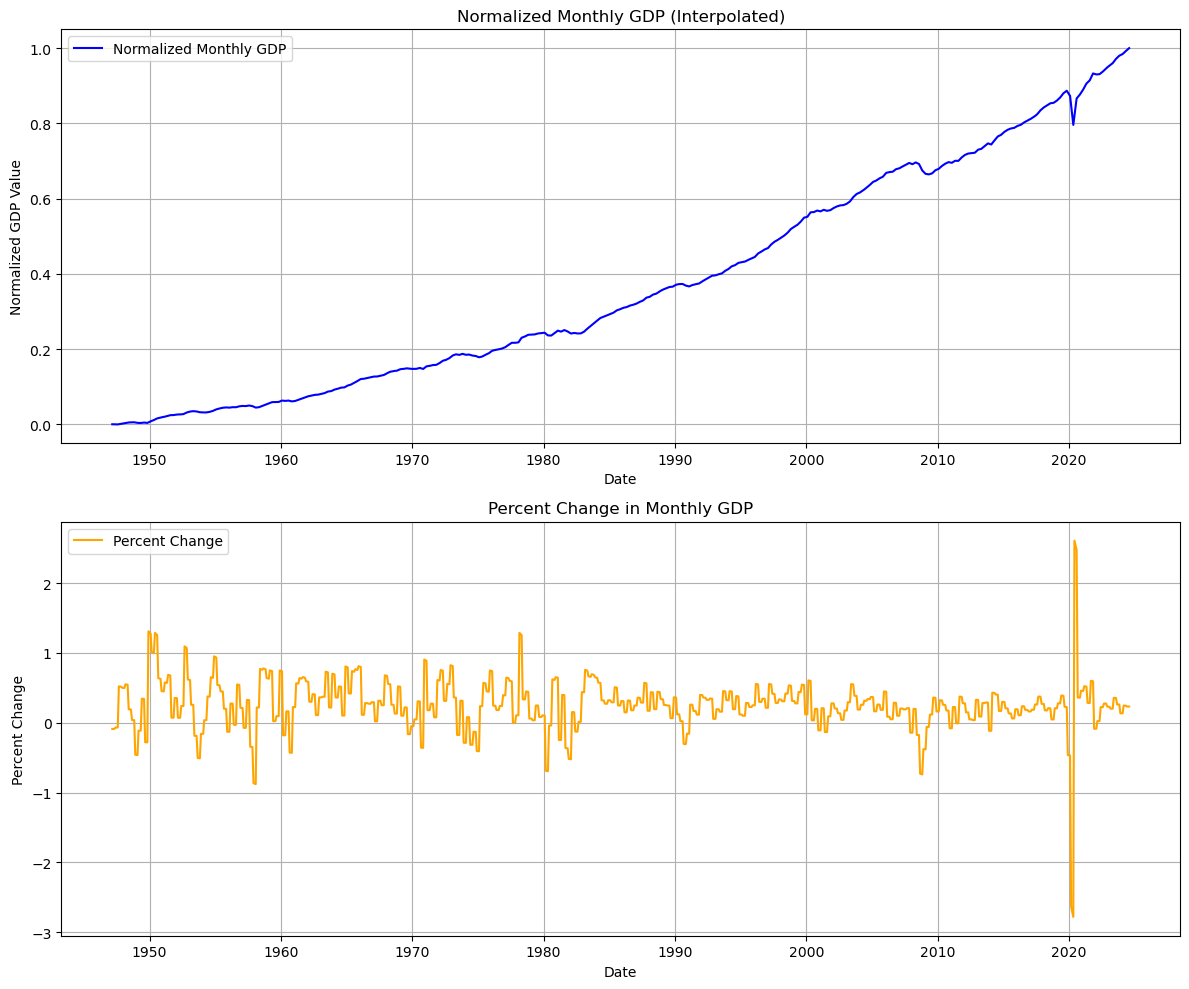

In [56]:
# Convert DATE to datetime and set as index
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.set_index('DATE', inplace=True)
gdp.sort_index(inplace=True)

# Resample to monthly frequency
gdp = gdp.resample('M').mean()
gdp = gdp.interpolate(method='linear')

# Calculate percent change
gdp['gdp_percent_change'] = gdp['GDPC1'].pct_change() * 100

# Normalize GDP values
gdp['GDPC1_normalized'] = (gdp['GDPC1'] - gdp['GDPC1'].min()) / (gdp['GDPC1'].max() - gdp['GDPC1'].min())

# Drop NaN values from percent change
gdp = gdp.dropna(subset=['gdp_percent_change'])

# Visualization
plt.figure(figsize=(12, 10))

# Monthly GDP (Normalized)
plt.subplot(2, 1, 1)
plt.plot(gdp.index, gdp['GDPC1_normalized'], label='Normalized Monthly GDP', color='blue')
plt.title('Normalized Monthly GDP (Interpolated)')
plt.xlabel('Date')
plt.ylabel('Normalized GDP Value')
plt.legend()
plt.grid(True)

# Percent Change in GDP
plt.subplot(2, 1, 2)
plt.plot(gdp.index, gdp['gdp_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change in Monthly GDP')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Data Date Range

In [57]:
import pandas as pd

# GDP Dataset
print("GDP Dataset:")
gdp.index = pd.to_datetime(gdp.index, errors='coerce')  # Ensure index is datetime
print("GDP Index Type:", gdp.index.dtype)
print("GDP Date Range:", gdp.index.min(), "to", gdp.index.max())

# Inflation Dataset
print("\nInflation Dataset:")
inflation['date'] = pd.to_datetime(inflation.index, errors='coerce')  # Convert 'date' column to datetime
inflation.set_index('date', inplace=True)  # Set 'date' as index
print("Inflation Index Type:", inflation.index.dtype)
print("Inflation Date Range:", inflation.index.min(), "to", inflation.index.max())

# Unemployment Dataset
print("\nUnemployment Dataset:")
unemployment['date'] = pd.to_datetime(unemployment.index, errors='coerce')  # Convert 'date' column to datetime
unemployment.set_index('date', inplace=True)  # Set 'date' as index
print("Unemployment Index Type:", unemployment.index.dtype)
print("Unemployment Date Range:", unemployment.index.min(), "to", unemployment.index.max())

# Yield Curve Dataset
print("\nYield Curve Dataset:")
yield_data['Date'] = pd.to_datetime(yield_data.index, errors='coerce')  # Convert 'Date' column to datetime
yield_data.set_index('Date', inplace=True)  # Set 'Date' as index
print("Yield Curve Index Type:", yield_data.index.dtype)
print("Yield Curve Date Range:", yield_data.index.min(), "to", yield_data.index.max())


GDP Dataset:
GDP Index Type: datetime64[ns]
GDP Date Range: 1947-02-28 00:00:00 to 2024-07-31 00:00:00

Inflation Dataset:
Inflation Index Type: datetime64[ns]
Inflation Date Range: 1947-02-28 00:00:00 to 2023-06-30 00:00:00

Unemployment Dataset:
Unemployment Index Type: datetime64[ns]
Unemployment Date Range: 1948-01-31 00:00:00 to 2024-05-31 00:00:00

Yield Curve Dataset:
Yield Curve Index Type: datetime64[ns]
Yield Curve Date Range: 1961-06-30 00:00:00 to 2024-11-30 00:00:00


### Align and Merge Datasets

In [58]:
# Align the date range to the common period
common_start_date = max(
    gdp.index.min(),
    inflation.index.min(),
    unemployment.index.min(),
    yield_data.index.min()
)
common_end_date = min(
    gdp.index.max(),
    inflation.index.max(),
    unemployment.index.max(),
    yield_data.index.max()
)

# Clip datasets to the common date range
gdp_aligned = gdp.loc[common_start_date:common_end_date, ['gdp_percent_change']]
inflation_aligned = inflation.loc[common_start_date:common_end_date, ['inflation_percent_change']]
unemployment_aligned = unemployment.loc[common_start_date:common_end_date, ['unemployment_percent_change']]
yield_curve_aligned = yield_data.loc[common_start_date:common_end_date, ['LongTermRate', 'Slope']]

# Merge datasets
merged_data = (
    gdp_aligned
    .merge(inflation_aligned, left_index=True, right_index=True, how='inner')
    .merge(unemployment_aligned, left_index=True, right_index=True, how='inner')
    .merge(yield_curve_aligned, left_index=True, right_index=True, how='inner')
)

# Display the merged data
print("Merged Data Summary:")
print(merged_data.info())
print(merged_data.head())


Merged Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 1961-06-30 to 2023-06-30
Freq: M
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gdp_percent_change           745 non-null    float64
 1   inflation_percent_change     745 non-null    float64
 2   unemployment_percent_change  745 non-null    float64
 3   LongTermRate                 745 non-null    float64
 4   Slope                        745 non-null    float64
dtypes: float64(5)
memory usage: 51.1 KB
None
            gdp_percent_change  inflation_percent_change  \
DATE                                                       
1961-06-30            0.636050                  0.000000   
1961-07-31            0.632030                  0.268097   
1961-08-31            0.653890                  0.066845   
1961-09-30            0.649642                  0.133601   
1961-10-31            0.645449      

### Exploratory Data Analysis

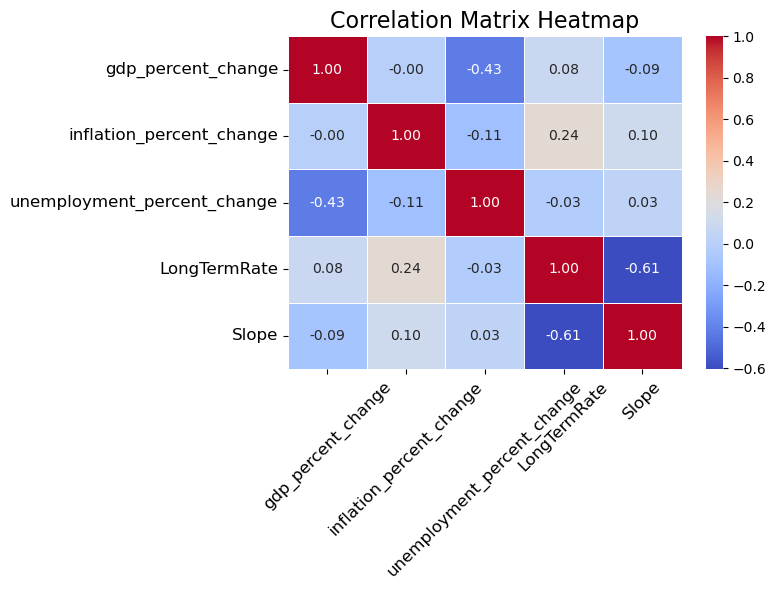

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


### Seasonal Decomposition

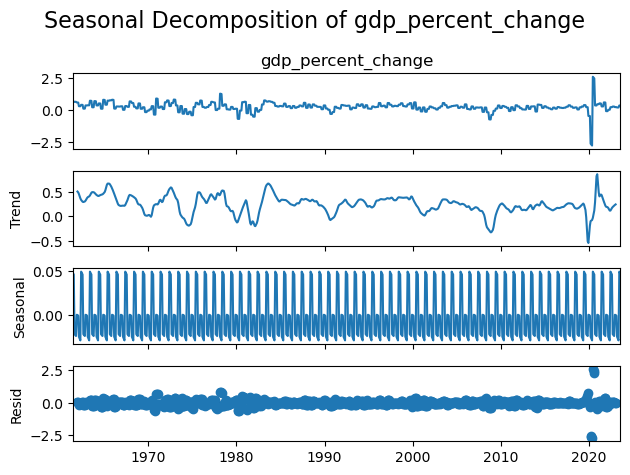

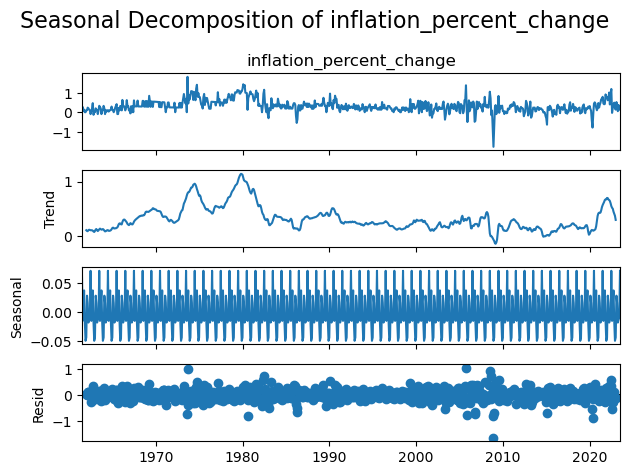

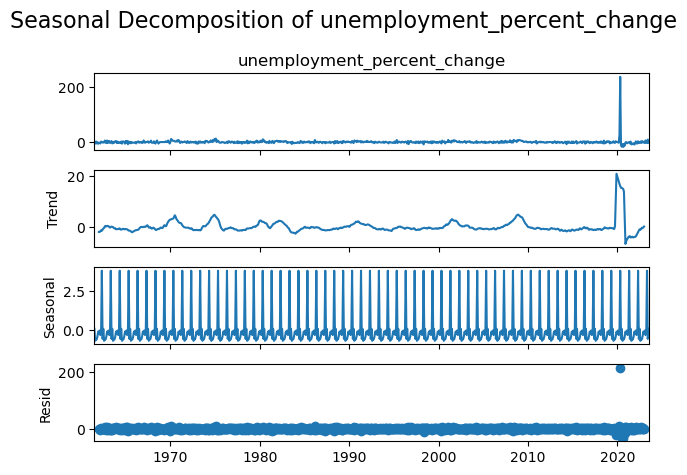

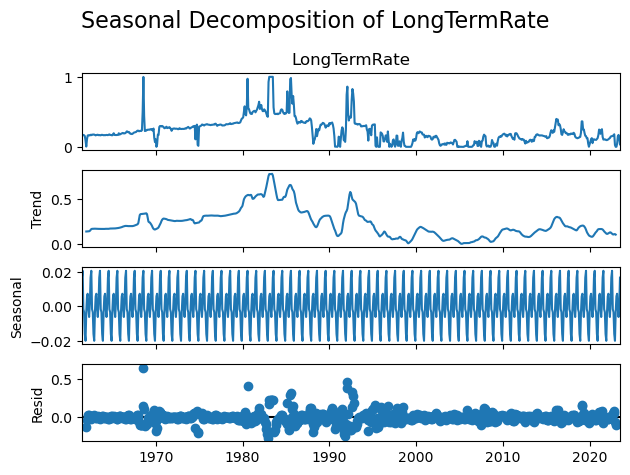

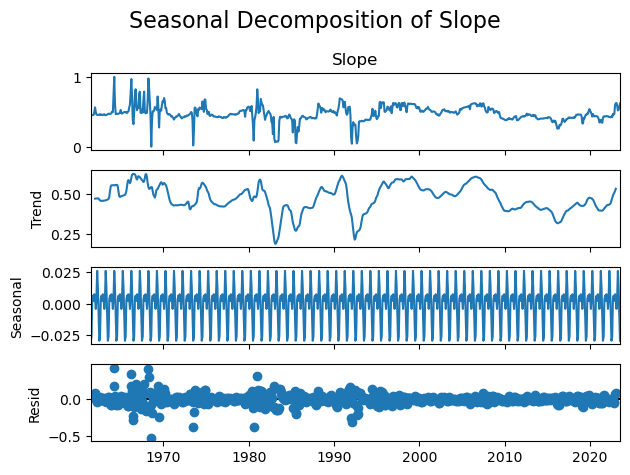

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Define a function for seasonal decomposition
def decompose_and_plot(data, column, model='additive', period=12):
    result = seasonal_decompose(data[column], model=model, period=period)
    result.plot()
    plt.suptitle(f"Seasonal Decomposition of {column}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Apply decomposition to all relevant columns
columns_to_decompose = ['gdp_percent_change', 'inflation_percent_change', 
                        'unemployment_percent_change', 'LongTermRate', 'Slope']

for col in columns_to_decompose:
    decompose_and_plot(merged_data, col)
